In [1]:
import numpy as np
np.random.seed(5)

import functions as fx
import classx as cl
import log_reg_functions as lrf
import loaddata as ld


import time
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import log_loss, f1_score

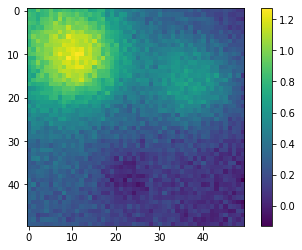

In [2]:
n=50

x = np.linspace(0,1,n)
y = x

x_mesh, y_mesh  = np.meshgrid(x,y)
noise_level     = 0.05
frank           = fx.FrankeFunction(x_mesh, y_mesh, noise_level)


plt.imshow(frank)
plt.colorbar()
plt.show()

frank=frank.ravel()
frank=frank.reshape([len(frank),1])



In [47]:
class ANN():
    def __init__(self, lmb=0, bias=0, eta=0.0001):
        self.lmb=lmb
        self.bias = bias
        self.layers=dict()
        self.n_layers=int()
        
        self.pred=dict()
        self.act=dict()
        self.eta=eta
        
    def add_layers(self, n_neurons=[20,5], n_features=[20,5], n_layers=2):
        self.n_layers=n_layers
        for i in range(n_layers):
            layer_weights = np.random.randn(n_features[i], n_neurons[i])
            self.layers['w'+str(i)] = layer_weights
            layer_bias = np.zeros(n_neurons[i]) + self.bias
            self.layers['b'+str(i)] = layer_bias
    
    def feed(self, design, activation=[lrf.sigmoid,lrf.sigmoid, lrf.sigmoid]):
        
        for i in range(self.n_layers):
            
            if i==0:
                self.pred[str(i)] = np.matmul(design, self.layers['w'+str(i)]) + self.layers['b'+str(i)]
                self.act[str(i)] = activation[i](self.pred[str(i)])
            else:
                self.pred[str(i)] = np.matmul(self.act[str(i-1)], self.layers['w'+str(i)]) + self.layers['b'+str(i)]                
                self.act[str(i)] = activation[i](self.pred[str(i)])
  
    def back(self, design, data, derivative=[lrf.sigmoid_deriv, lrf.sigmoid_deriv, lrf.sigmoid_deriv]):
        
        for i in np.arange(self.n_layers-1,0,-1):
            if i==self.n_layers-1:
                error = self.act[str(i)] - data
            else:
                error = np.matmul(error, self.layers['w'+str(i+1)].T) * derivative[i](self.act[str(i)])
            if i == 0:
                gradients_weights = (np.matmul(design.T, error))/len(data)
                gradients_bias = (np.sum(error, axis=0))/len(data)
            else:
                gradients_weights = (np.matmul(self.act[str(i-1)].T, error))/len(data)
                gradients_bias = (np.sum(error, axis=0))/len(data)
            
            if self.lmb>0.0:
                gradients_weights += self.lmb * self.layers['w'+str(i)]
            
            self.layers['w'+str(i)] -= self.eta * gradients_weights
            self.layers['b'+str(i)] -= self.eta * gradients_bias
   
    def feed_out(self, design, activation=[lrf.sigmoid,lrf.sigmoid, lrf.sigmoid]):
        
        for i in range(self.n_layers):
            
            if i==0:
                self.pred[str(i)] = np.matmul(design, self.layers['w'+str(i)]) + self.layers['b'+str(i)]
                self.act[str(i)] = activation[i](self.pred[str(i)])
            else:
                self.pred[str(i)] = np.matmul(self.act[str(i-1)], self.layers['w'+str(i)]) + self.layers['b'+str(i)]                
                self.act[str(i)] = activation[i](self.pred[str(i)])
        return self.act
    
    def train(self, epochs, batch_size, x, y, activation, derivative, verbose=False):
        tmp=int(len(y)/batch_size)
        Niter = min(200,tmp)
        indexes = np.arange(len(y))
        for i in range(epochs):
            for j in range(Niter):
                datapoints = np.random.choice(indexes, size=batch_size, replace=False)
                batch_x = x[datapoints,:]
                batch_y = y[datapoints]
                
                self.feed(batch_x, activation)
                self.back(batch_x,batch_y, derivative)
            if verbose:
                pred = self.feed_out(x, activation)[str(self.n_layers-1)]
                cost = fx.MSE(pred.ravel(),y.ravel())
                print('Epoch', i, 'loss', cost )
        

In [48]:
neural_net = ANN(lmb=lmbmax, bias=0.5, eta=etamax)            
neural_net.add_layers(n_features=[19,50,20], n_neurons = [50,20,1] , n_layers=3)

design=fx.DesignDesign(x,y,5)
design=np.delete(design, [0,1], axis=1)


activation = [lrf.relu, lrf.sigmoid, lrf.nooutact]
derivative = [lrf.relu_deriv, lrf.sigmoid_deriv, lrf.nooutact]

start = time.time()


epochs=10000
batch_size=500
neural_net.train(epochs, batch_size, design,frank,activation,derivative)

end = time.time()
print(end - start)


53.8352792263031


In [3]:
import NeuralNetwork as nn
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)


etamax=eta_vals[4]
lmbmax=lmbd_vals[0]

neural_net = nn.ANN(lmb=lmbmax, bias=0.5, eta=etamax)            
neural_net.add_layers(n_features=[19,50,20], n_neurons = [50,20,1] , n_layers=3)

design=fx.DesignDesign(x,y,5)
design=np.delete(design, [0,1], axis=1)


activation = [lrf.relu, lrf.sigmoid, lrf.nooutact]
derivative = [lrf.relu_deriv, lrf.sigmoid_deriv, lrf.nooutact]

start = time.time()


epochs=10000
batch_size=500
neural_net.train(epochs, batch_size, design,frank,activation,derivative)

end = time.time()
print(end - start)



57.389307260513306


In [4]:
pred = neural_net.feed_out(design, activation)['2']

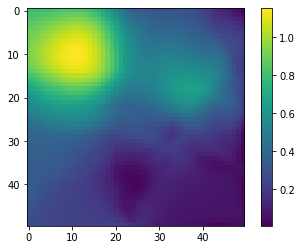

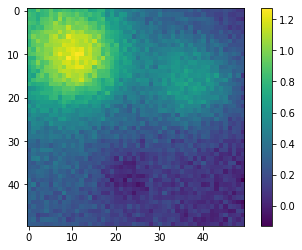

0.00293311284565836

In [5]:
plt.imshow(pred.reshape([n,n]))
plt.colorbar()
plt.show()

plt.imshow(frank.reshape([n,n]))
plt.colorbar()
plt.show()

fx.MSE(pred,frank)

In [ ]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


design=fx.DesignDesign(x,y,5)
design=np.delete(design, [0,1], axis=1)

X_train = design
Y_train = frank.ravel()
# only one simple layer with 100 neurons
n_hidden_neurons = (50,20)
epochs = 10
# store models for later use
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)
# store the models for later use
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
sns.set()
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs*100)
        dnn.fit(X_train, Y_train)
        DNN_scikit[i][j] = dnn
        train_accuracy[i][j] = dnn.score(X_train, Y_train)
        print(train_accuracy[i][j])
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()



0.00991271573109298
-0.060490123610319246
-0.1339730566762296
0.0012729561341146003
0.0014564367276934664


C:\Users\vemundst\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


-0.03408353812622966


C:\Users\vemundst\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.0007500948038522415
0.5699776599800969
0.566376580841532
0.5758979031456151
0.5682312889560797
0.5774529520119995
0.14377281062897396
-0.00021075922940338998
0.734959173602161
0.8123524666211841
0.7748631181624083
0.772798617619696
0.7132800421136876
0.42704870516827015
-0.000288916849222165
0.9191113681566313
0.9338488354602266
0.9074402807730414
0.8780116630705758


In [8]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
design=fx.DesignDesign(x,y,5)
design=np.delete(design, [0,1], axis=1)

X_train = design
Y_train = frank.ravel()
# only one simple layer with 100 neurons
n_hidden_neurons = (50,20)
epochs = 10
# store models for later use
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)
# store the models for later use
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)


etamax=eta_vals[4]
lmbmax=lmbd_vals[0]

dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbmax, learning_rate_init=etamax, max_iter=epochs*100)
dnn.fit(X_train, Y_train)
DNN_scikit = dnn
train_accuracy = dnn.score(X_train, Y_train)
print(train_accuracy)

0.9542965925520638


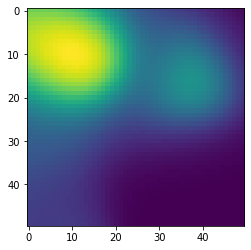

0.0038954719728336172


In [9]:
pred = dnn.predict(X_train)


plt.imshow(pred.reshape([n,n]))
plt.show()

print(fx.MSE(pred,frank.ravel()))

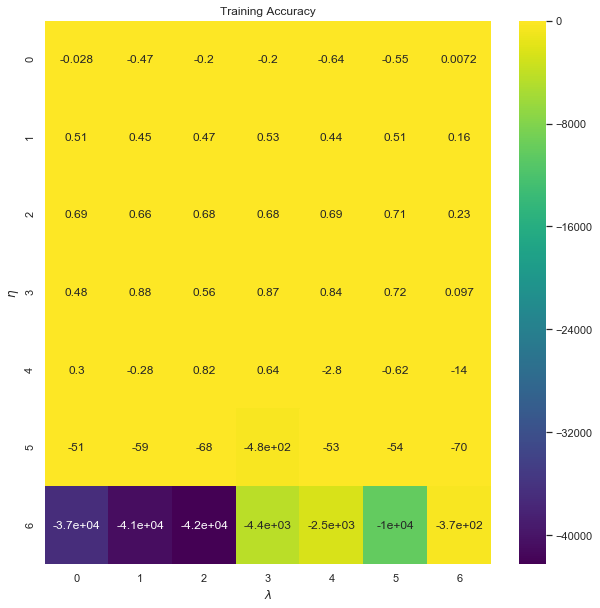

In [266]:
# Common imports
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def FrankeFunction(x,y):
	term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
	term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
	term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
	term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
	return term1 + term2 + term3 + term4


def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X


# Making meshgrid of datapoints and compute Franke's function
n = 4
N = 100
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
z = FrankeFunction(x, y)
X = create_X(x, y, n=n)    

# only training data, no advanced splitting
X_train = X
Y_train = z
# only one simple layer with 100 neurons
n_hidden_neurons = 100
epochs = 100
# store models for later use
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)
# store the models for later use
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
sns.set()
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs*100)
        dnn.fit(X_train, Y_train)
        DNN_scikit[i][j] = dnn
        train_accuracy[i][j] = dnn.score(X_train, Y_train)

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()



0.01 0.01


0.8720989451128397


In [288]:
pred = dnn.predict(X_train)
pred.shape

print(z.shape)

(100,)


In [289]:
X_train.shape

(100, 15)

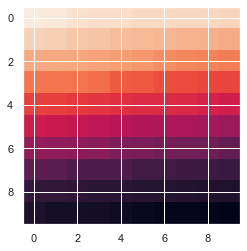

In [291]:
plt.imshow(pred.reshape([10,10]))
plt.show()

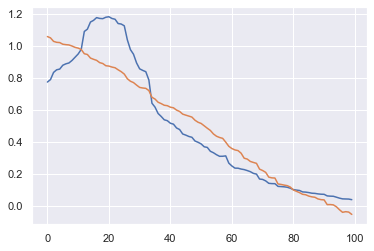

In [292]:
plt.plot(z)
plt.plot(pred)
plt.show()

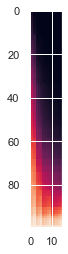

In [293]:
plt.imshow(X)


In [300]:
d=fx.DesignDesign(x,y,4)


In [303]:

d.shape

(10000, 15)